# Robust Varibad Analysis

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import cross_entropy_sampler as cem
import general_utils as utils
import analysis

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)

/tmp/ipykernel_3008059/867683384.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Configuration

In [2]:
ENV_NAME = 'HumanoidMass-v0'
TITLE = ENV_NAME[:-3]
ENV_SHORT = 'humm'
TASKS = ['mass']
TASK_DIM = len(TASKS)
METHODS = ('varibad', 'cembad', 'cvrbad')
NM_MAP = dict(varibad='VariBAD', cvrbad='CVaR-ML', cembad='RoML')
SEEDS = list(range(15))  # 30
ALPHA = 0.05

### The CEM

In [3]:
TRANSFORMATION = lambda x: 2 ** (2*(x-0.5))
YLIM = (0, 2)
SMOOTH = 20
CEM_SEED = 0

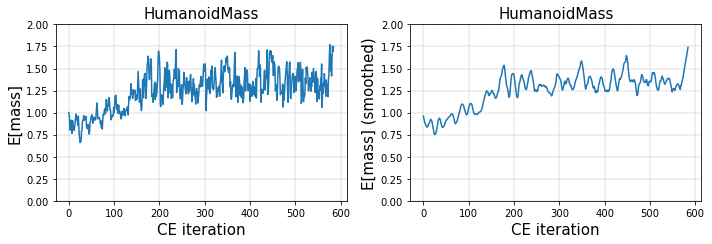

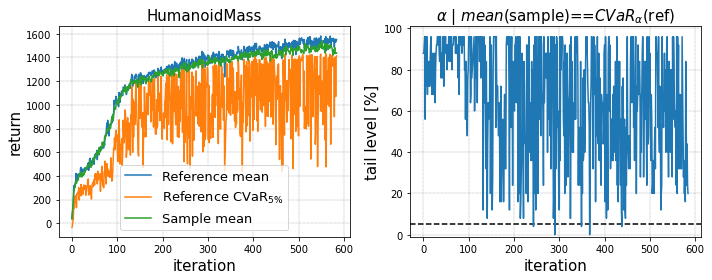

In [4]:
ce, c1, c2, axs1, axs2 = analysis.cem_analysis(
    ENV_NAME, TASK_DIM, TRANSFORMATION, YLIM, SMOOTH, title=TITLE, tasks=TASKS, seed=CEM_SEED)
plt.sca(axs1[0])
plt.savefig(f'outputs/{ENV_SHORT}_sample_dist.png', bbox_inches='tight', dpi=300)
plt.sca(axs2[0])
plt.savefig(f'outputs/{ENV_SHORT}_cem.png', bbox_inches='tight', dpi=300)

## Test results

In [5]:
%%time
rr, rra, rrm, rrc, rr0, rra0 = analysis.load_test_data(
    ENV_NAME, ENV_SHORT, METHODS, SEEDS, ALPHA, 'best', nm_map=NM_MAP)
rr

Test tasks: 1008
CPU times: user 43.6 s, sys: 219 ms, total: 43.8 s
Wall time: 43.8 s


,ep,ret,task0,method,seed
0,0,1720.766479,0.944335,VariBAD,0
1,1,1719.915527,0.944335,VariBAD,0
2,0,1513.906616,1.319355,VariBAD,0
3,1,1489.883179,1.319355,VariBAD,0
4,0,1758.607422,0.900947,VariBAD,0
...,...,...,...,...,...
84667,1,625.464172,0.508780,CVaR-ML,13
84668,0,765.172241,1.154397,CVaR-ML,13
84669,1,867.504761,1.154397,CVaR-ML,13
84670,0,637.869080,0.718385,CVaR-ML,13


Test returns vs. task - over all seeds aggregated:
CPU times: user 1.17 s, sys: 7.97 ms, total: 1.17 s
Wall time: 1.17 s


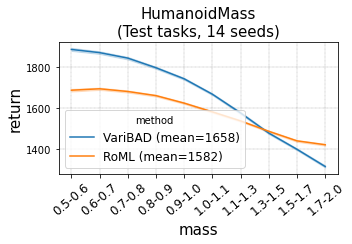

In [6]:
%%time
axs = analysis.show_test_vs_tasks(rra[rra.method!='CVaR-ML'], None, TITLE, TASKS, min_ndigits=1)
plt.savefig(f'outputs/{ENV_SHORT}_tasks.png', bbox_inches='tight', dpi=300)

In [7]:
# if FINISHED:
#     axs = analysis.summarize_test(rra0, rr0, ALPHA)

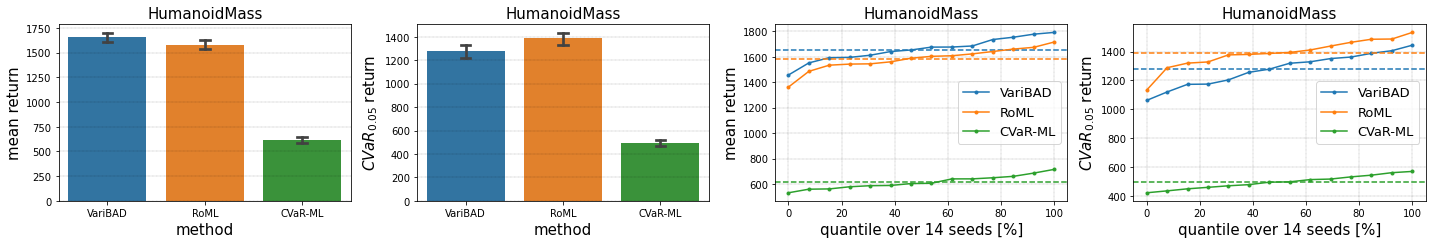

In [8]:
axs = analysis.summarize_test_over_seeds(rrm, rrc, ALPHA, TITLE, barplot=True)

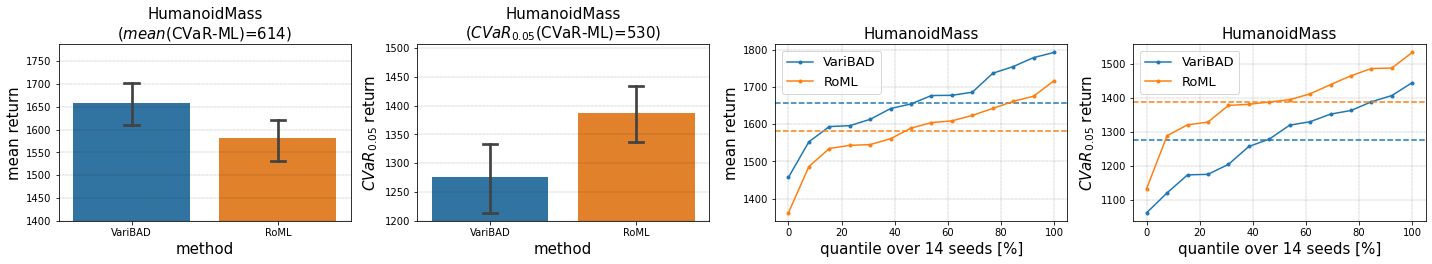

In [9]:
axs = analysis.summarize_test_over_seeds(rrm[rrm.method!='CVaR-ML'], rrc[rrc.method!='CVaR-ML'], ALPHA, TITLE, barplot=True)
axs[0].set_title(f'{TITLE}\n($mean$(CVaR-ML)={rrm.ret[rrm.method=="CVaR-ML"].mean():.0f})', fontsize=15)
axs[0].set_ylim((1400, None))
axs[1].set_title(f'{TITLE}\n($CVaR_{{{ALPHA}}}$(CVaR-ML)={analysis.get_cvar_fun(ALPHA)(rrm.ret[rrm.method=="CVaR-ML"]):.0f})', fontsize=15)
axs[1].set_ylim((1200, None))
plt.savefig(f'outputs/{ENV_SHORT}_summary.png', bbox_inches='tight', dpi=300)

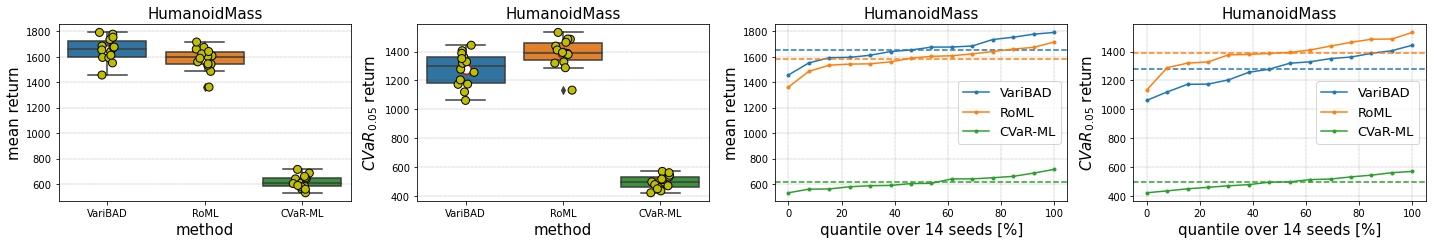

In [10]:
axs = analysis.summarize_test_over_seeds(rrm, rrc, ALPHA, TITLE)

### Final models test (not best over validation)

Test tasks: 1008
Test returns vs. task - over all seeds aggregated:
CPU times: user 42.9 s, sys: 288 ms, total: 43.2 s
Wall time: 43.2 s


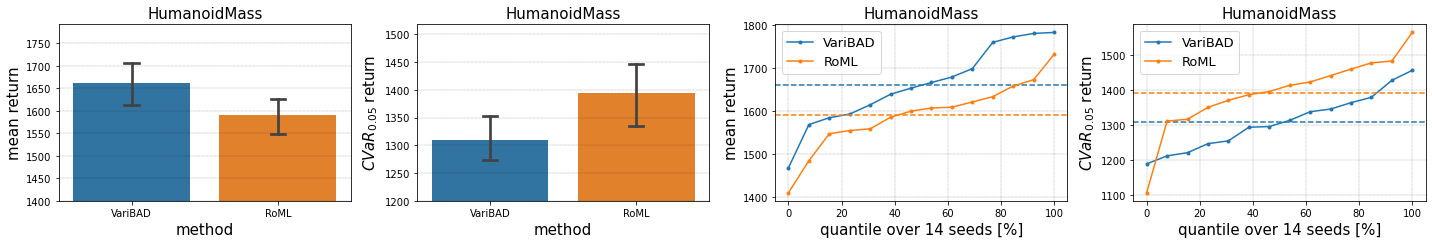

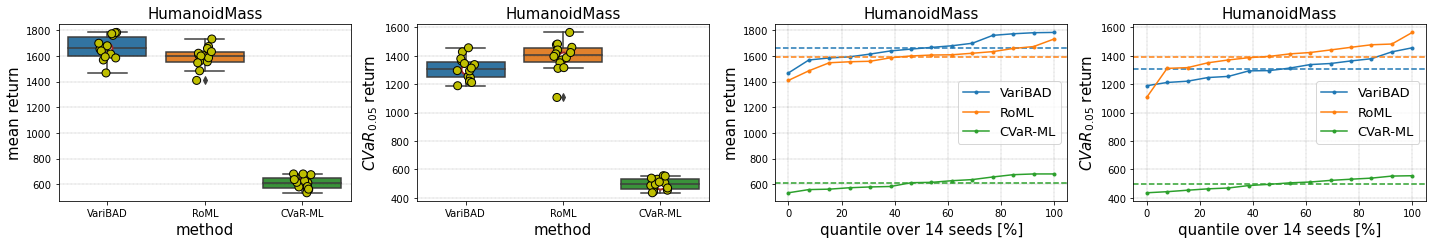

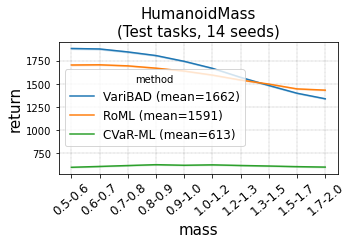

In [11]:
%%time
bb, bba, bbm, bbc, bb0, bba0 = analysis.load_test_data(
    ENV_NAME, ENV_SHORT, METHODS, SEEDS, ALPHA, 'final', nm_map=NM_MAP)

axs = analysis.summarize_test_over_seeds(bbm[bbm.method!='CVaR-ML'], bbc[bbc.method!='CVaR-ML'], ALPHA, TITLE, barplot=True)
axs[0].set_ylim((1400, None))
axs[1].set_ylim((1200, None))
plt.savefig(f'outputs/{ENV_SHORT}_f_summary.png', bbox_inches='tight', dpi=300)

axs = analysis.summarize_test_over_seeds(bbm, bbc, ALPHA, TITLE)
axs2 = analysis.show_test_vs_tasks(bba, bba0, TITLE, TASKS)

## Validation results

In [12]:
%%time
dd, dda, ddm, ddc, dd0, dda0, task_dim = analysis.load_train_data(
    ENV_NAME, ENV_SHORT, METHODS, SEEDS, ALPHA, nm_map=NM_MAP)
dd

humm_varibad_0__24:10_12:18:22
humm_varibad_1__24:10_23:12:12
humm_varibad_2__25:10_10:12:00
humm_varibad_3__25:10_21:07:02
humm_varibad_4__27:10_20:49:30
humm_varibad_5__28:10_08:30:32
humm_varibad_6__28:10_20:10:02
humm_varibad_7__29:10_07:51:56
humm_varibad_8__29:10_19:48:09
humm_varibad_9__30:10_06:28:39
humm_varibad_10__14:12_20:49:24
humm_varibad_11__09:12_17:15:53
humm_varibad_12__10:12_04:39:06
humm_varibad_13__10:12_15:58:14
humm_cembad_0__24:10_12:18:26
humm_cembad_1__24:10_23:14:42
humm_cembad_2__25:10_10:18:02
humm_cembad_3__25:10_21:14:08
humm_cembad_4__27:10_20:49:42
humm_cembad_5__28:10_08:31:09
humm_cembad_6__28:10_20:11:45
humm_cembad_7__29:10_07:47:18
humm_cembad_8__29:10_19:41:34
humm_cembad_9__30:10_06:29:31
humm_cembad_10__15:12_06:17:00
humm_cembad_11__09:12_17:15:50
humm_cembad_12__10:12_04:31:16
humm_cembad_13__10:12_15:56:09
humm_cvrbad_0__09:12_17:35:02
humm_cvrbad_1__10:12_05:13:58
humm_cvrbad_2__10:12_17:07:24
humm_cvrbad_3__11:12_04:51:09
humm_cvrbad_4__11:

,iter,task_id,ep,ret,task0,method,seed
0,-1,0,0,9.125528,0.731751,VariBAD,0
1,-1,0,1,62.050671,0.731751,VariBAD,0
2,-1,1,0,73.681656,0.785910,VariBAD,0
3,-1,1,1,2.708477,0.785910,VariBAD,0
4,-1,2,0,87.309868,1.331609,VariBAD,0
...,...,...,...,...,...,...,...
126331,2324,13,1,609.840942,1.510485,CVaR-ML,13
126332,2324,14,0,616.077393,1.359755,CVaR-ML,13
126333,2324,14,1,651.916931,1.359755,CVaR-ML,13
126334,2324,15,0,724.901733,0.615840,CVaR-ML,13


In [13]:
# axs = analysis.show_task_distribution(dda0, rra0, TASKS)

In [14]:
# %%time
# axs = analysis.show_validation_vs_tasks(dda, TASKS)

In [15]:
# %%time
# axs = analysis.show_validation_results(dda0, ALPHA)

CPU times: user 190 ms, sys: 18 µs, total: 190 ms
Wall time: 189 ms


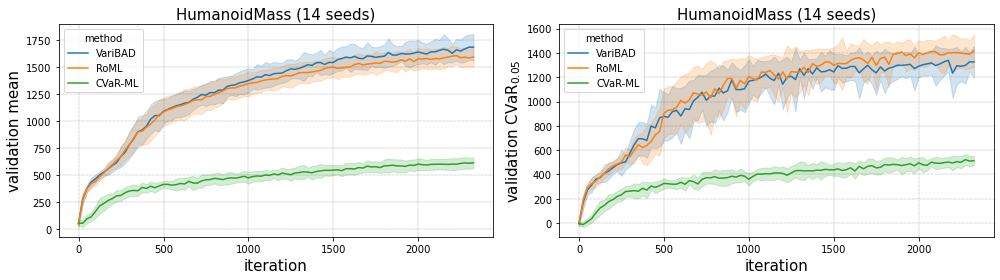

In [16]:
%%time
axs = analysis.show_validation_results_over_seeds(ddm, ddc, ALPHA, TITLE)

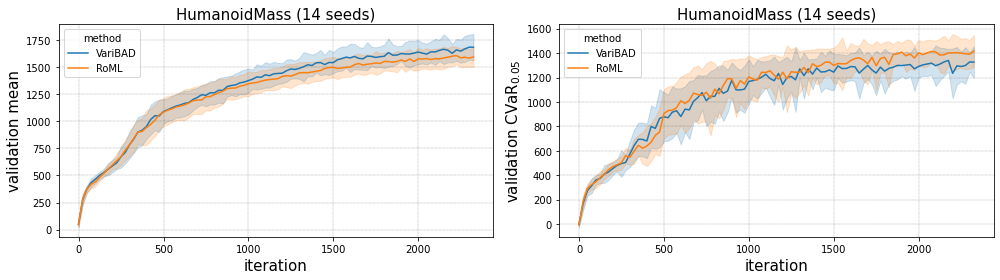

In [18]:
axs = analysis.show_validation_results_over_seeds(ddm[ddm.method!='CVaR-ML'], ddc[ddc.method!='CVaR-ML'], ALPHA, TITLE)
plt.savefig(f'outputs/{ENV_SHORT}_valid.png', bbox_inches='tight', dpi=300)